<a href="https://colab.research.google.com/github/pnkjkpvt/SAFE_OCR/blob/master/SAFE_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install necessary modeules

In [ ]:
!pip install opencv-python 
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install pyyaml h5py  # Required to save models in HDF5 format

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.


Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'My Drive'


Imports

In [ ]:
import os
from os import listdir
from os.path import isfile, join

import csv
import re

import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pytesseract


Setting Constants

In [ ]:
DATA_PATH = F"/content/gdrive/My Drive/SAFE_OCR/data/"
FILE_PATH = DATA_PATH+"images/"
TEMPLATE_FILE = DATA_PATH+"dashed 1.jpg"  ## File path to the exam-paper template file
MAPPING_FILE = DATA_PATH+"roll-numbers.csv"

MODEL_PATH = F"/content/gdrive/My Drive/SAFE_OCR/models/"

LEGAL_FILE_EXTENSION = ['jpg','jpeg','png','JPG','JPEG','PNG']

PAGE_SCALE = 0.5

Getting Image Files

In [ ]:
## Here we're hardcoding the approximate location of Name and Roll_no fields.
## TODO identify these regions automatically
name_box = [386, 36, 1230, 172]    #Box parameters for Name field
roll_box = [1400, 32, 2010, 166]    #Box parameters for Roll_no filed


files = [FILE_PATH + f for f in listdir(FILE_PATH) if isfile(join(FILE_PATH, f))]


Defining Useful functions

In [ ]:
def to_grayscale(image):
    # image = cv2.convertScaleAbs(image, alpha=1, beta=0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [ ]:
def to_binary_image(image, inverted=False):
    # Source : https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
    gray = to_grayscale(image)

    if (inverted):
        image = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)[1]  
    else:
        image = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)[1]
        # image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,27,2)

    return image

In [ ]:
## Post-processing step on OCR output
def clean_roll_number(rollno):
    # Here there is a need to refine wrong predictions of characters
    # Remove spaces from Roll number
    rollno = re.sub('\\s+', '', rollno)
    # 'o' is probably 0
    rollno = re.sub('[o,O]', '0', rollno)
    # I, i, J, j, l are probably 1
    rollno = re.sub('[I,J,l]', '1', rollno)
    # S, s is probably 5 or 8
    rollno = re.sub('[s,S]', '5', rollno)
    # q is probably 9
    rollno = re.sub('[q]', '9', rollno)
    # b is probably 6
    rollno = re.sub('[b]', '6', rollno)
    # Neglect all special character
    rollno = rollno.upper()
    rollno = re.sub('[^A-Z,0-9]', '', rollno)
    return rollno

In [ ]:
##Longest common subsequence
def lcs(X, Y):
    # find the length of the strings
    m = len(X)
    n = len(Y)

    # declaring the array for storing the dp values
    L = [[None] * (n + 1) for i in range(m + 1)]

    """Following steps build L[m + 1][n + 1] in bottom up fashion 
    Note: L[i][j] contains length of LCS of X[0..i-1] 
    and Y[0..j-1]"""
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                L[i][j] = 0
            elif X[i - 1] == Y[j - 1]:
                L[i][j] = L[i - 1][j - 1] + 1
            else:
                L[i][j] = max(L[i - 1][j], L[i][j - 1])

                # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1]
    return L[m][n]

In [ ]:
## Edit Distance
# An adaptation of @ https://www.geeksforgeeks.org/edit-distance-dp-5/
def editDist(str1, str2):
    len1 = len(str1)
    len2 = len(str2)
    # Create a table to store results of subproblems
    dp = [[0 for x in range(len2 + 1)] for x in range(len1 + 1)]
    # Fill d[][] in bottom up manner
    for i in range(len1 + 1):
        for j in range(len2 + 1):

            # If first string is empty, only option is to insert all characters of second string
            if i == 0:
                dp[i][j] = j  # Min. operations = j

            # If second string is empty, only option is to remove all characters of second string
            elif j == 0:
                dp[i][j] = i  # Min. operations = i

            # If last characters are same, ignore last char and recur for remaining string
            elif str1[i - 1] == str2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]

            # If last character are different, consider all possibilities and find minimum
            else:
                dp[i][j] = 1 + min(dp[i][j - 1],  # Insert
                                   dp[i - 1][j],  # Remove
                                   dp[i - 1][j - 1])  # Replace

    return dp[len1][len2]


In [ ]:
## Function to find best matching record from database against given input
"""Param : algorithm = 'ed' or 'lcs'
              
"""

def find_record(name, roll, algorithm='ed'): 
    found_record = []
    max_sim_score = 0    
    least_dist = 100
    with open(MAPPING_FILE, 'r') as mapping_file:
        record_list = list(csv.reader(mapping_file, delimiter=','))

        # Iterate over the list
        for record in record_list[1:]:  # TODO- First the program should check if there is no record in row 1, and only then snip it.
            name_record = record[1]     # TODO - get rid of numerical indices. Actual indices of 'Name' or 'roll_no' column may be different
            roll_record = record[2]
            if (name != '' or roll != '') and (name_record != '' and roll_record != ''):

                if (algorithm == 'lcs'):    # if LCS algorithm is chosen
                    sim_score = lcs(name + roll, name_record + roll_record)
                    # sim_score = sim_score/len(name_record)
                    if sim_score > max_sim_score:  # then the current record is more similar
                        max_sim_score = sim_score
                        found_record = [record[1:3]]  # TODO - get rid of constant indices.
                    elif sim_score == max_sim_score:
                        found_record.append(record[1:3])  # TODO - get rid of constant indices.

                elif (algorithm =='ed'):      # if Edit Distance algorithm is chosen
                    dist = editDist(name + roll, name_record + roll_record)
                    if least_dist > dist: # then the current record is more similar
                        least_dist = dist
                        found_record = [record[1:3]]  # TODO - get rid of constant indices.
                    elif least_dist == dist:
                        found_record.append(record[1:3])  # TODO - get rid of constant indices.

    # print(found_record)
    return found_record

Character Segmentation by identifying rectangular boxes in the image

In [ ]:
# Finding Contours of the image
def get_contours(img):
    # converting to gray scale binary. 
    threshold = to_binary_image(img)

    # Detecting contours 
    contours,_=cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    return contours

In [ ]:
# Python code to detect a rectangle from an image. 
"""Adapted from 
https://www.geeksforgeeks.org/python-detect-polygons-in-an-image-using-opencv/
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html
"""

def segment_characters (img2, contours):
    # # Reading image 
    # img2 = cv2.imread(DATA_PATH+'Name.jpg')
    
    # converting to gray scale binary. 
    # threshold = to_binary_image(img2) 
      
    # Detecting contours 
    # contours,_=cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

    # Data structure to save rectangle boundaries
    boundaries = {}

    # To stop same rectangle to be recorded twice
    control_median = -1000

    # To select the smallest bounding box for a given character
    contorl_area = 100000

    # Searching through every region selected.
    for cnt in contours : 
        area = cv2.contourArea(cnt) 
      
        # Shortlisting the regions based on there area. 
        # TODO : Proper finetuning is required as per the page sizes
        if area > 800 and area < 10000:       

            bounds = cv2.boundingRect(cnt)
            [x,y,w,h] = bounds
            x_median = x + w/2      ## TODO : Medians of two adjecent boxes can't be very close. Handle this corner case

            ## Save coordinates in proper data structure so that they can be sorted and be used for cropping digits
            if (abs(control_median - x_median) > w/2):  # If two boxes are appropriatelt apart.            
                control_median = x_median
                control_area = area
                boundaries[x_median] = bounds
            
            elif (abs(control_median - x_median) < w/4 and area < control_area):    # If two boxes are too close, then choose the smallest one
                boundaries[x_median] = bounds

            # Color boxes with background color to remove them from image
            color = (255,255,255)
            img2 = cv2.rectangle(img2,(x,y), (x+w,y+h), color, 4)
            # cv2_imshow(img2)

    char_boundary = []
    for i in sorted(boundaries.keys()):
        char_boundary.append(boundaries[i])
  
    # print (char_boundary)
    cv2_imshow(img2)  
    return img2, char_boundary


Localising digits in the box

In [ ]:
def localise_character(box):
    #Find location of digit in the box
        box_arr = np.array(box)
        
        top = 0
        for row in box_arr:
            if (np.sum(row) >= 255): break            
            top = top+1
        # print("Top :", top)
        
        bottom = box_arr.shape[0]
        for row in box_arr[::-1]:
            if (np.sum(row) >= 255): break            
            bottom = bottom-1
        # print ("Bottom :", bottom)
        
        left = 0
        for row in np.transpose(box_arr):
            if (np.sum(row) >= 255): break            
            left = left+1
        # print ("Left :", left)

        right = box_arr.shape[1]
        for row in np.transpose(box_arr)[::-1]:
            if (np.sum(row) >= 255): break            
            right = right-1
        # print ("Right :", right)

        LR_mean = int((left+right)/2)
        TB_mean = int((top+bottom)/2)
        offset = int((max(bottom-top, right-left))/2)

        top = max(TB_mean-offset,0)
        bottom = top + 2*offset
        left = max(LR_mean-offset,0)
        right = left + 2*offset

        return top, bottom, left, right

# Processing images Using trained models

Using model trained on MNIST data-set to identify digits in roll number

In [ ]:
import keras
from keras.models import model_from_json
from keras.models import model_from_config
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


##Loading saved models
def load_trained_MNIST_model ():
    model_dir = MODEL_PATH+'MNIST_Model/'
    model_file = open(model_dir + 'model.json', 'r')
    loaded_model_json = model_file.read()
    model_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_dir + "model.h5")
    print("Loaded model from disk")

    # Create a basic model instance
    # Model configuration is saved in config.json file

    loaded_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    
    return loaded_model

Prepare data and feed it to model for prediction

In [ ]:
def process_data_for_model(org_image, contours):
    # print(len(contours))

    ## For MNIST model we need to invert the image color
    image = to_binary_image(org_image, True)
    
    data_arr = []

    for contour in contours:
        [x,y,w,h] = contour

        #Remove boundaries
        box = image[y+3:y+h-3, x+3:x+w-3] 

        # No need to process nearly empty boxes
        if np.sum(box[y+5:y+h-5, x+5:x+w-5]) > 255*10 :
            continue

        ## TODO - Before padding, ensure that there are no straight lines in the image.
        ## TODO - To keep some gap on all 4 sides, we can pad the image by 2 pixel width on all sides and crop localised characters from that image
        # Pad the image appropriately
        # box = np.pad(array=box, pad_width=int(box.shape[1]/2), mode='constant', constant_values=0) 
        top, bottom, left, right = localise_character(box)
        
        digit = box[top:bottom, left:right]        
        cv2_imshow(digit)
        # Resize to 28x28 image
        digit = cv2.resize(digit, (28,28))       
        
        ## Cross check the image
        # cv2_imshow(digit)
        resized = np.array(digit)
        resized = resized.reshape(28,28,1)
        data_arr.append(resized)

    # print (np.array(data_arr).shape)
    return np.array(data_arr)

# Processing Hand written text with OCR and Trained models
Using model trained on MNIST dataset improved recognition of digits in roll_no field. However the accuracy is not very good. This can be attributed to the handwritten data obtained from students.. The model's accuracy should improve if the model is trained with these new data over time. There are scope for improvements in character segmentation algorithm used.


Tesseract OCR did not perform well for recognising handwritten names. Tweaking config parameters don't seem to improve the accuracy.

Loaded model from disk
Name : PANKAJZT kKUMAR


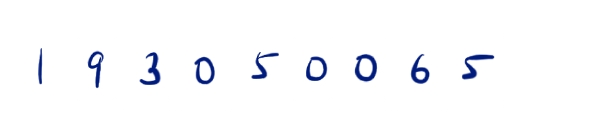

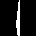

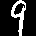

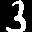

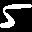

Roll_No : 143050065
[['Pankaj Kumar', '193050065']]
Name : Pank@jy Ku mah


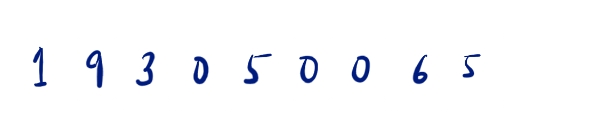

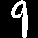

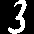

Roll_No : 43060065
[['Pankaj Kumar', '193050065']]
Name : Panta j Kumar


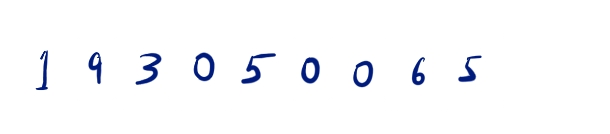

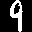

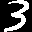

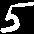

Roll_No : 43050065
[['Pankaj Kumar', '193050065']]
Name : Pankaj kK u4@ma y


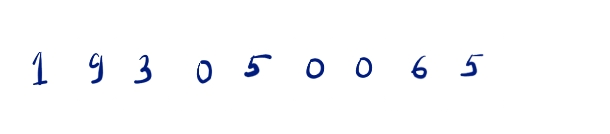

Roll_No : 43050065
[['Pankaj Kumar', '193050065']]
Name : PANKAJ KUMAR


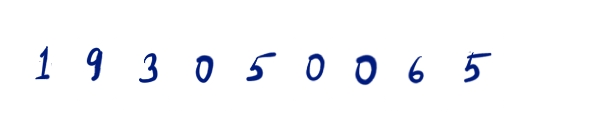

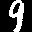

Roll_No : 44050065
[['Pankaj Kumar', '193050065']]
Name : AVtNAstkumMA®


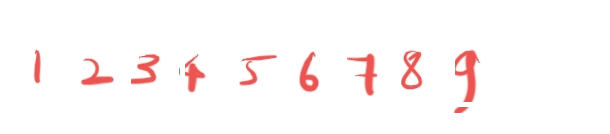

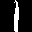

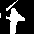

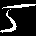

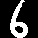

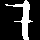

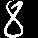

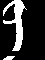

Roll_No : 125856761
[['Avinsah Kumar', '123456789']]
Name : KRVtNASH €IUNAL


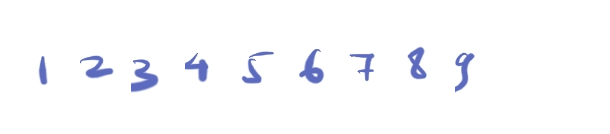

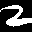

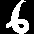

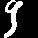

Roll_No : 25466486
[['Avinsah Kumar', '123456789']]
Name : Aven aSn Kuma ed


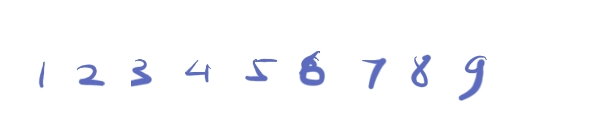

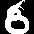

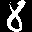

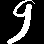

Roll_No : 25458167
[['Avinsah Kumar', '123456789']]
Name : Aviwne Sw Ka mak


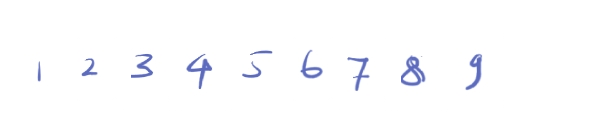

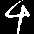

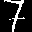

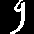

Roll_No : 115436447
[['Avinsah Kumar', '123456789']]


In [ ]:
## Load required trained models
loaded_model = load_trained_MNIST_model()

## 
for filename in files:
    if (filename.split('.')[1] in LEGAL_FILE_EXTENSION):
        ## Load images here
        # print('\n' + filename)
        img = cv2.imread(filename)

        ## Crop name section for faster recognision
        name_img = img[name_box[1]:name_box[3], name_box[0]:name_box[2]]
        name_img = to_binary_image(name_img)
        # cv2_imshow(name_img)
        name_text = pytesseract.image_to_string(name_img,
                                                config='--psm 10 --oem 3 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')
        print('Name :', name_text)


        ## Crop roll_number section for faster recognision
        # roll_img = img[roll_box[1]:roll_box[3], roll_box[0]:roll_box[2]]
        # roll_img = to_binary_image(roll_img)
        # cv2_imshow(roll_img)        
        # roll_text = pytesseract.image_to_string(roll_img, config='--psm 6')# --oem 3 -c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')
        # roll_text = clean_roll_number(roll_text)
        # print('Roll no :', roll_text)

        ##==========================================================
        ##    Processing Roll_number section using MNIST model
        ##==========================================================
        roll_img = img[roll_box[1]:roll_box[3], roll_box[0]:roll_box[2]]
        contours = get_contours (roll_img)
        roll_img, char_boundary = segment_characters (roll_img, contours)

        # cv2_imshow(roll_img[y:y+h, x:x+w])
        processed_digits = process_data_for_model(roll_img, char_boundary)
        roll_text = loaded_model.predict_classes(processed_digits)  #This is a list at this time
        roll_text = ''.join([str(elem) for elem in roll_text])
        print ('Roll_No :',roll_text)
        ##----------------------------------------------------------

        ## Mathcing with existing records
        found_record = find_record(name_text, roll_text)
        print(found_record)


In [ ]:
''' This code finds the regions with all the boxes. i.e. this code will find the Roll_no region and Name region separately'''

"""
img = cv2.imread(DATA_PATH+'Name.jpg',0)
h, w = img.shape[:2]
kernel = np.ones((15,15),np.uint8)

e = cv2.erode(img,kernel,iterations = 2)  
d = cv2.dilate(e,kernel,iterations = 1)
ret, th = cv2.threshold(d, 150, 255, cv2.THRESH_BINARY_INV)

mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(th, mask, (100,100), 255); # position = (200,200)
out = cv2.bitwise_not(th)
out= cv2.dilate(out,kernel,iterations = 3)
cnt, h = cv2.findContours(out,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print (cnt)
print (h)
for i in range(len(cnt)):
            area = cv2.contourArea(cnt[i])
            if(area>10000 and area<100000):
                  print("here")
                  mask = np.zeros_like(img)
                  cv2.drawContours(mask, cnt, i, 255, -1)
                  x,y,w,h = cv2.boundingRect(cnt[i])
                  print(x,y,w,h)
                  crop= img[ y:h+y,x:w+x]
                  cv2_imshow(crop )

# cv2.destroyAllWindows()

"""

'\nimg = cv2.imread(DATA_PATH+\'Name.jpg\',0)\nh, w = img.shape[:2]\nkernel = np.ones((15,15),np.uint8)\n\ne = cv2.erode(img,kernel,iterations = 2)  \nd = cv2.dilate(e,kernel,iterations = 1)\nret, th = cv2.threshold(d, 150, 255, cv2.THRESH_BINARY_INV)\n\nmask = np.zeros((h+2, w+2), np.uint8)\ncv2.floodFill(th, mask, (100,100), 255); # position = (200,200)\nout = cv2.bitwise_not(th)\nout= cv2.dilate(out,kernel,iterations = 3)\ncnt, h = cv2.findContours(out,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)\nprint (cnt)\nprint (h)\nfor i in range(len(cnt)):\n            area = cv2.contourArea(cnt[i])\n            if(area>10000 and area<100000):\n                  print("here")\n                  mask = np.zeros_like(img)\n                  cv2.drawContours(mask, cnt, i, 255, -1)\n                  x,y,w,h = cv2.boundingRect(cnt[i])\n                  print(x,y,w,h)\n                  crop= img[ y:h+y,x:w+x]\n                  cv2_imshow(crop )\n\n# cv2.destroyAllWindows()\n\n'

In [ ]:
import numpy as np  
x = [[1, 3, 2, 5, 4], [1, 3, 2, 5, 4],[1, 3, 2, 5, 4],[1, 3, 2, 5, 4]]
y = np.pad(array=x, pad_width=3, mode='constant', constant_values=0)  
print (y)

[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 3 2 5 4 0 0 0]
 [0 0 0 1 3 2 5 4 0 0 0]
 [0 0 0 1 3 2 5 4 0 0 0]
 [0 0 0 1 3 2 5 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]
